# Wijklabels

Balázs Dukai, Ravi Peters  
2024-02-12

In [2]:
import pandas as pd
import numpy as np

from wijklabels.woningtype import Bouwperiode

# 1. Summary

The Voorbeeldwoningen 2022 study describes the distribution of energy
labels per vormfactor range for each dwelling type of the WoON 2018
study. The latest release of the 3DBAG data set (`2023.10.08`) provides
the surface areas for calculating the vormfactor for each Pand. This
work explores the possibility of calculating the vormfactor for each
dwelling within a Pand and applying the energy label distributions of
the Voorbeeldwoningen 2022 study to estimate the energy label
distribution of each neighborhood of the Netherlands.

We validate our estimated energy labels against the labels registered in
the EP-Online database. The validation shows varying deviation between
the estimated and EP-Online labels. The labels *A* and *B* have 0 median
deviation, the labels *A+*, *A++* are one label overestimated, the
labels *C*, *D* are one label underestimated. The rest of the labels
have a deviation of two labels or more from the EP-Online labels.

There are two major limitations that impact the accuracy of the results.
First, the 3D location of appartements is not known, therefore strong
assumptions are made on the interior layout of a Pand, leading to a
mainly inaccurate estimation of the appartament subtypes. This
inaccuracy propagates to the estimation of the vormfactor and then
energy label of appartements. Second, the energy label distributions in
the Voorbeeldwoningen 2022 study are incomplete, therefore 14% of the
input dwelling could not receive an energy label, and 32% of the
validated dwellings have an energy label that is not possible to assign
due to missing data in the Voorbeeldwoningen 2022 study.

# 2. Data sources

## 2.1 Spreiding van energielabels

The RVO (2022) study provides a representative sample of energy label
distributions per dwelling type and construction period. The
distribution is two-dimensional, one dimension is the energy label, the
second dimension is the vormfactor of the dwelling. However, the
described distributions are not continuous. For example, in case of
Flatwoningen from the period 1965-1974, there is no data in the
vormfactor range 1,00-1,50 and labels A+++-D, see
<a href="#fig-woon2022-spreiding" class="quarto-xref">Figure 1</a>. Such
gaps have a significant impact on the quality of our results (see
<a href="#sec-only-possible" class="quarto-xref">Section 5.2.1</a>).

If the dwelling has a vormfactor in a range where there is no energy
label data in the distribution, the dwelling is not assigned an energy
label.

The energy label distributions were extracted from the Excel file
`Illustraties spreiding Energielabel in WoON2018 per Voorbeeldwoning 2022 - 2023 01 25.xlsx`,
which we received from RVO.

<figure id="fig-woon2022-spreiding">
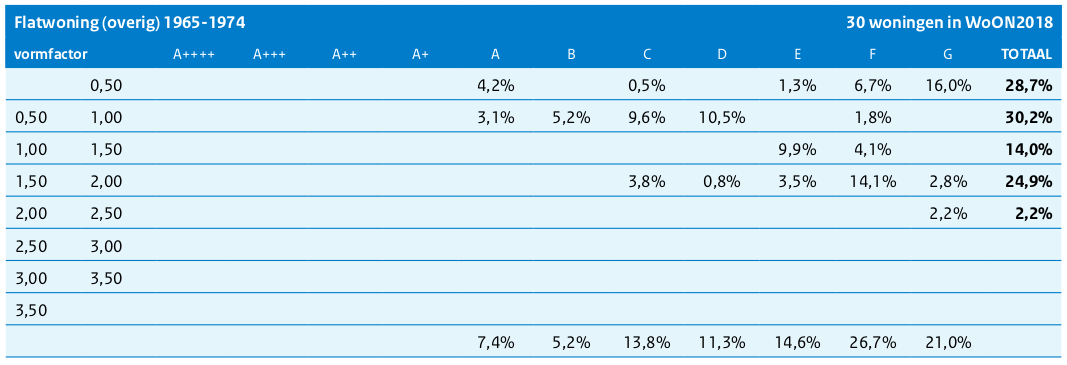
<figcaption>Figure 1: Energy label distribution of flatwoningen, <span
class="citation" data-cites="RVO_Voorbeeldwoningen_2022">RVO
(2022)</span></figcaption>
</figure>

## 2.2 BAG and 3DBAG

The
[BAG](https://www.kadaster.nl/zakelijk/registraties/basisregistraties/bag)
data set is the official register of buildings and addresses of the
Netherlands. The BAG contains two object types that are relevant for
this study, *Pand* and *Verblijfsobject (VBO)*. Each VBO contains
information about its usage in the `gebruiksdoel` attribute. For this
study, only those VBO are usere which usage includes `woonfunctie`. The
[3DBAG](https://3dbag.nl) is an extension of the BAG data set,
containing the outer 3D shell of the Pand objects. The 3DBAG does not
contain information on the VBOs. We used the 3DBAG version `2023.10.08`.
The 3DBAG `2023.10.08` is based on the BAG 2.0 Extract with a release
date of *08.09.2023*.

The BAG extract of `08.09.2023` contains *10.877.129* Pand objects and
*10.144.833* Verblijfsobjecten.  
The 3DBAG version `2023.10.08` that is based the mentioned BAG extract,
contains *10.360.281* Pand objects.  
The party walls dataset, that is based on the 3DBAG, contains
*10.363.460* Pand objects.  
There are *5.646.848* Pand and *8.721.692* VBO with gebruiksdoel that
includes `woonfunctie`.

In the span of 2023, the project “Levering databestand 3D-BAG” funded by
RVO, extended the 3DBAG with 3D surface areas. The surface information
is included in the 3DBAG since version `2023.10.08`. However, we used
the CSV file (`3dbag_v20231008_rvo_export.csv`) that was delivered
directly to RVO. The reason for using the CSV file is purely to simplify
the data preparation process.

## 2.3 Construction year

The RVO (2022) study determines at most seven construction year periods,
depending on the dwelling type. We adhere to the same periods for
categorizing the buildings on their construction year. The periods are
listed in
<a href="#tbl-count-period-type" class="quarto-xref">Table 1</a>
together with the count of dwellings in the results.

In [3]:
df = pd.read_csv(
    '/home/balazs/Development/wijklabels/tests/data/output/labels_individual.csv',
    usecols=["bouwperiode", "woningtype", "woningtype_pre_nta8800"],
    converters={
      "bouwperiode": Bouwperiode.from_str
    }
)
total = df.count().iloc[0]  # count non-NA (!) cells
pt_crosstab = pd.crosstab(
    df["bouwperiode"],
    columns=df["woningtype_pre_nta8800"],
    margins=True,
    margins_name="Totaal"
)
ct = pt_crosstab.apply(
    lambda col: list(map(lambda cnt: f"{cnt} ({round(cnt / total * 100)}%)", col))
).replace(
    "0 (0%)", ""
).reset_index(
    drop=False
)
ct.columns.name = "Woningtype"
ct["Bouwperiode"] = ct["bouwperiode"].apply(
    lambda bp: bp.format_pretty() if bp != "Totaal" else bp
)
ct.drop("bouwperiode", axis=1, inplace=True)
ct.set_index("Bouwperiode", inplace=True)
ct

## 2.4 CBS Neighborhoods

The neighborhoods are used for aggregating the dwelling energy labels.
The neighborhood boundaries are retrieved from the Centraal Bureau voor
de Statistiek. The BAG Pand objects are assigned to a neighborhood with
an intersection test. Every BAG Pand is assigned to only one
neighborhood.

Version of CBS Wijken en Buurten: 2022 v1, [link to
data](https://service.pdok.nl/cbs/wijkenbuurten/2022/atom/downloads/wijkenbuurten_2022_v1.gpkg)

## 2.5 EP-Online for validation

*“EP-Online is de officiële landelijke database waarin energielabels en
energieprestatie-indicatoren van gebouwen zijn opgenomen.” “EP-Online”
(2023)* We use the energy labels from EP-Online as “ground truth” for
the validation of our estimated labels. Therefore, we assessed if we can
consider the set of dwellings with a registered label on EP-Online a
reliable reliable reference for comparison.

The EP-Online database contains energy labels that were determined using
different methods. We only use the labels that were determined with the
NTA8800 method. That is, the `Pand_berekeningstype` contains `NTA 8800`.
In total, these records constitue to *1.284.241* VBOs.

<a href="#fig-dist-bag-ep-online-bp" class="quarto-xref">Figure 2</a>
shows that both the BAG and the EP-Online data set have a very similar
distribution of dwellings across all construction year periods. This
indicates that the registered energy labels in EP-Online represent well
the complete set of dwellings in the Netherlands, when considering the
construction period.

<figure id="fig-dist-bag-ep-online-bp">
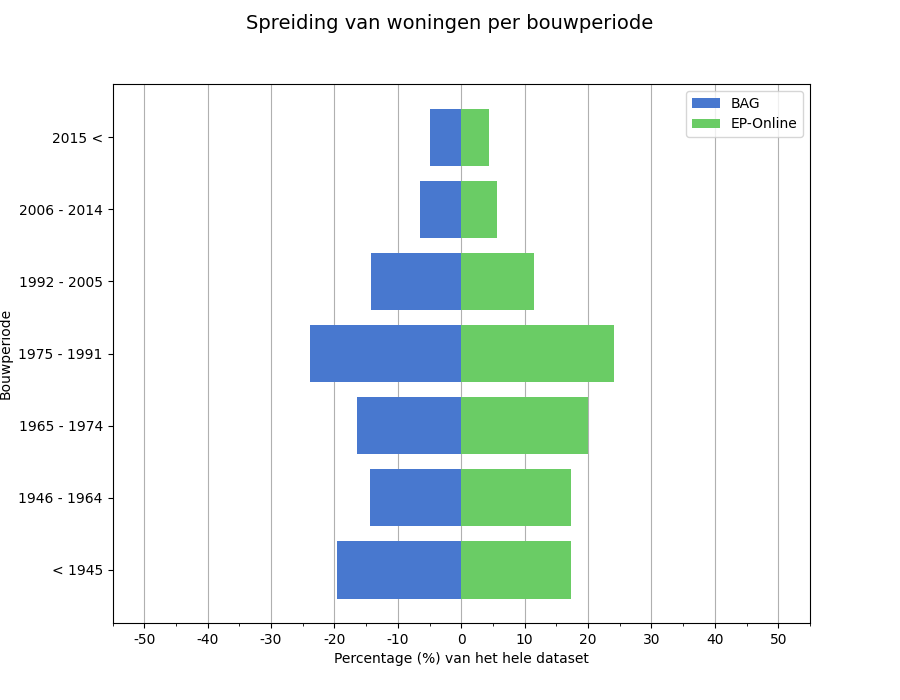
<figcaption>Figure 2: Spreiding van woningen per bouwperiode in de BAG
en in de EP-Online gegevens</figcaption>
</figure>

<a href="#fig-dist-bag-ep-online-wt" class="quarto-xref">Figure 3</a>
shows that both the BAG and the EP-Online data set have a very similar
distribution of dwellings across all dwelling types. This indicates that
the registered energy labels in EP-Online represent well the complete
set of dwellings in the Netherlands, when considering the dwelling
types. However, there are two caveats that need to be considered here.
Firstly, the comparison does not include the apartment subtypes, only
the main *apartement* type. This is, because there is no reliable method
for determining the apartment subtypes for the complete BAG data set.
Secondly, the dwelling types of the BAG were estimated by ourselves,
because there we do not have authoritative dwelling type information for
the whole BAG data set (see
<a href="#sec-woningtype" class="quarto-xref">Section 3.2</a>).

<figure id="fig-dist-bag-ep-online-wt">
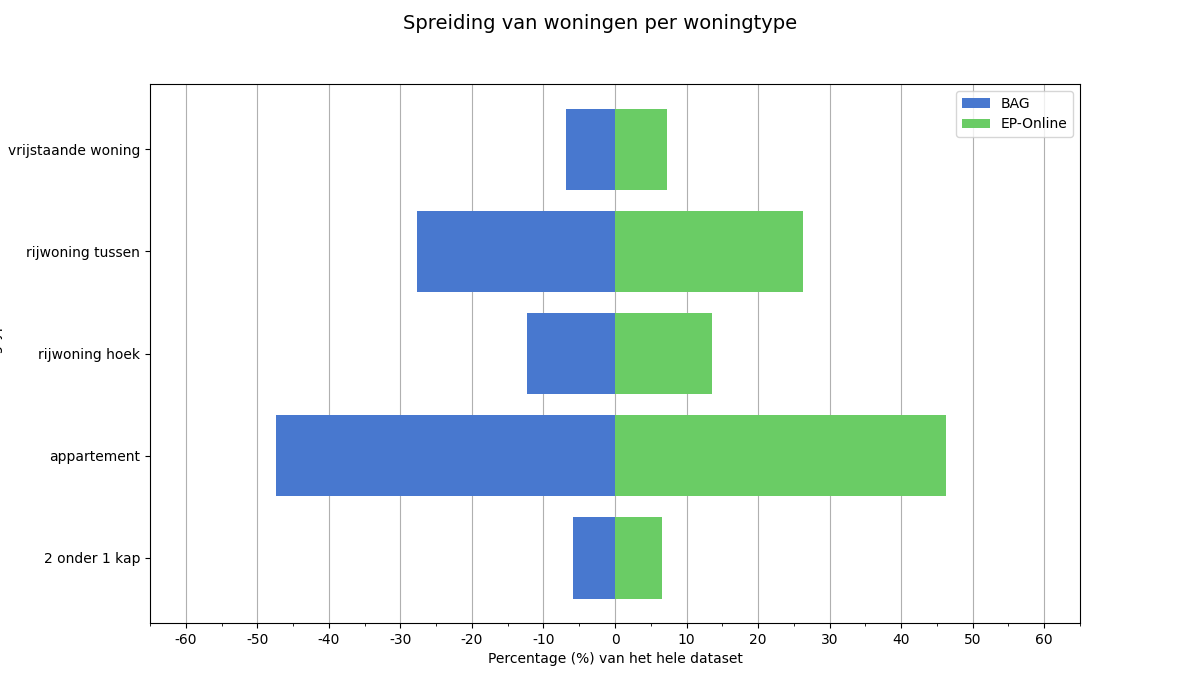
<figcaption>Figure 3: Spreiding van woningen per woningtype in de BAG en
in de EP-Online gegevens</figcaption>
</figure>

<a href="#fig-dist-coverage" class="quarto-xref">Figure 4</a> shows that
75% of neighborhoods have a coverage of 4-19%, while 50% of the
neighborhoods has 8% coverage or less. Nearly all neighborhoods have at
least 3% coverage. This indicates that nearly all neighborhoods have
reference labels available in the EP-Online data set.

<figure id="fig-dist-coverage">
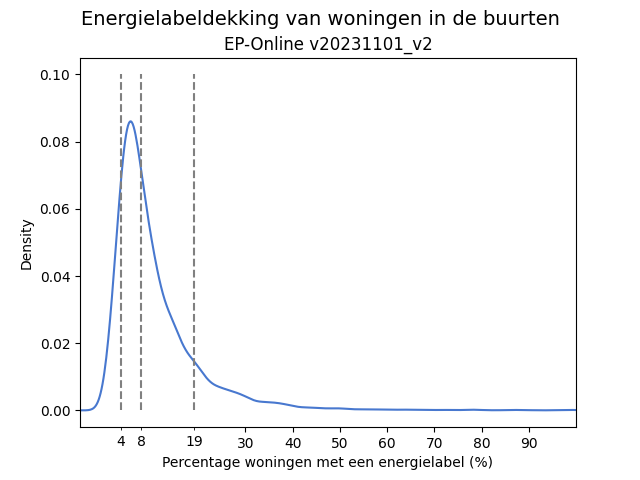
<figcaption>Figure 4: Energielabeldekking van woningen in de
buurten</figcaption>
</figure>

From the these analysis we conclude that the EP-Online database is a
reliable reference for validating our estimated energy labels.

# 3. Method

This work estimates the vormfactor for individual dwellings and the
energy label distribution of neighborhoods of the Netherlands. Due to
the lack of suitable, national data, we worked with often severe
assumptions on the parameters of a dwelling. The steps for these
assumptions are listed below in their order in the energy label
estimation process.

1.  Estimating the number of floors of a Pand.
2.  Estimating the type of a dwelling, both for eengezinswoningen and
    meergezinswoningen.
3.  Converting from a NTA8800 appartament type (e.g. *apartement -
    hoekdak*) to a pre-NTA8800 appartament type (e.g. *galerij*).
4.  Estimating the vormfactor of an appartement. Even if the exact
    number of floors and the correct appartement type, such as *hoekdak*
    were known, it wouldn’t be possible to exactly calculate the
    vormfactor appartaments, due to the variations in internal layouts
    of buildings. However, it would be possible to make a much more
    accurate estimation.
5.  Estimating the energy label of an individual dwelling from the
    probability of energy labels documented in the Voorbeelwoningen 2022
    study.

## 3.1 Number of floors

The number of floors of a Pand is required for distributing the VBO-s
across the floors in a meergezinswoning. We compute the number of floors
by dividing the gebruiksoppervlakte by the area of the roofprint taken
from the 3DBAG. The gebruiksoppervlakte is the sum of each VBO’s
`oppervlakte` of a Pand in the BAG. The roofprint area is the [totale
oppervlakte begane
grond](https://docs.3dbag.nl/nl/schema/attributes/#b3_opp_grond),
without any underground parts. The resulting value is rounded up to the
nearest whole number, which gives us the number of floors.

## 3.2 Dwelling types

Dwellings are classified into distinct types. The current
classification, as used by the NTA8800 method, is listed in
<a href="#tbl-nta8800-types" class="quarto-xref">Table 2</a>. In case of
appartements, hoek/tussen refers to the horizontal position of the
appartement in the building, while vloer/midden/dak/dakvloer refers to
its vertical position. For the sake of simplicity, we refer to this
classification as **NTA8800-types**.

| Eengezinswoningen  | Meergezinswoningen           |
|--------------------|------------------------------|
| vrijstaande woning | appartement - hoekvloer      |
| 2 onder 1 kap      | appartement - hoekmidden     |
| rijwoning tussen   | appartement - hoekdak        |
| rijwoning hoek     | appartement - hoekdakvloer   |
|                    | appartement - tussenvloer    |
|                    | appartement - tussenmidden   |
|                    | appartement - tussendak      |
|                    | appartement - tussendakvloer |

Table 2: Dwelling types used by the NTA8800 method

Before the introduction of the NTA8800 method, dwellings were classified
slightly differently, see
<a href="#tbl-pre-nta8800-types" class="quarto-xref">Table 3</a>. This
is the classification used by the RVO (2022) study. For the sake of
simplicity, we refer to this classification as **pre-NTA8800-types**.

| Eengezinswoningen  | Meergezinswoningen |
|--------------------|--------------------|
| vrijstaande woning | maisonette         |
| 2 onder 1 kap      | galerij            |
| rijwoning tussen   | portiek            |
| rijwoning hoek     | flat (overig)      |

Table 3: Dwelling types used in RVO (2022)

The types of the single family houses are equivalent before and after
NTA8800. On the other hand, there is no clear relation between the types
of the meergezingswoningen before and after NTA8800.

This work requires that we know both the *NTA8800* and the *pre-NTA8800*
type of each dwelling. The *pre-NTA8800* type is needed, because that is
used by RVO (2022), and the *NTA8800* type is needed, because that is
used by the validation data on EP-Online.

We first estimate the *NTA8800* type and then convert that to a
*pre-NTA8800* type. The classification of eengezinswoningen is fairly
straightforward and can be done using a conventional GIS analysis on the
BAG polygons. Classifying the meergezingswoningen is much harder because
this depends on the interior architecture of a Pand, and we have no
knowledge of this from our input datasets. Therefore a number of strong
assumptions and educated guesses had to be made to come up with a
method.

### 3.2.1 Classification of a Pand

Each BAG Pand are classified by clustering the intersecting BAG
geometries. For example, a row of five row-houses forms one cluster,
because they form a group of connected objects. We determine the types
*vrijstaand/2 onder 1 kap/rijwoning* from the number of buildings in the
cluster. In case of a *rijwoning*, we determine its position
*hoek/tussen* from the number intersections with other buildings in the
cluster.

Misclassification occurs if the intersections are incorrectly
determined, usually, because there is a small gap between BAG polygons
that are supposed to be touching. Thus, in order to improve the
classification of eengezinswoningen, the BAG polygons need topological
correction so the gaps and overlaps are corrected.

### 3.2.2 Eengezinswoningen

If a pand only contains a single VBO, then we consider the VBO an
*eengezinswoning* and the VBO receives the classification of the Pand.

### 3.2.3 Meergezinswoningen

The meergezingswoningen consist of a single main type, *appartement*. If
a Pand contains more than one VBO, then all of its VBOs are classified
as *appartement*.

The *appartement* subtypes are determined from the vertical and
horizonal position of the VBO within the pand. Firstly, the VBO-s are
distributed across the floors (see
<a href="#sec-floors" class="quarto-xref">Section 3.1</a>) of the Pand
to determine their vertical position. Each floor is assigned the same
number of appartements, which is calculated by dividing the number of
VBO-s by the number of floors. We call the *number of appartements per
floor* `N`. Then the total appartements in the pand are distributed so
that the first `N` is assigned to the ground floor (*vloer*), the second
`N` is assigned to the top floor (*dak*) and the rest is distributed
evenly across the floors in between (*midden*). If a `N` equals the
total number of appartements, then the appartements are classified as
*dakvloer*.

Secondly, the appartements are distributed horizontally on each floor.
We assume two configurations for the layout of the appartements, single
row or double row. The choice between single or double row depends on
the number of appartements per floor and a random choice. If the number
of appartements per floor is less than or equal three, then a single row
layout is chosen, otherwise there is a 50% chance for a double row
layout. Now, the number of *hoek* appartements are estimated based on
the classification of the pand and the previously determined layout. If
there are remaining appartements on the floor that are not classified as
*hoek*, they are classified as *tussen*.

## 3.3 Conversion of appartement types to pre-NTA8800 types

The RVO (2022) study uses the pre-NTA8800 dwelling types, while the
EP-Online database uses the NTA8800 dwelling types for the energy labels
that are calculated with the NTA8800 method. This work relies on the
results of the RVO (2022) study to estimate the energy label of
dwellings, therefore we convert the previously determined NTA8800
appartement type to pre-NTA8800 types. Since there is no direct relation
between the two classification, we can only estimate the pre-NTA8800
types.

We assign the pre-NTA8800 type to the appartement based on the
distribution of pre-NTA8800 types in the EP-Online database and the
construction date of the dwelling, see
<a href="#fig-woningtype-bouwjaar" class="quarto-xref">Figure 5</a>. For
example, if the dwelling was built in the period of 1965-1974, there is
an 84% chance that it receives the *flatwoning (overig)* pre-NTA8800
type.

<figure id="fig-woningtype-bouwjaar">
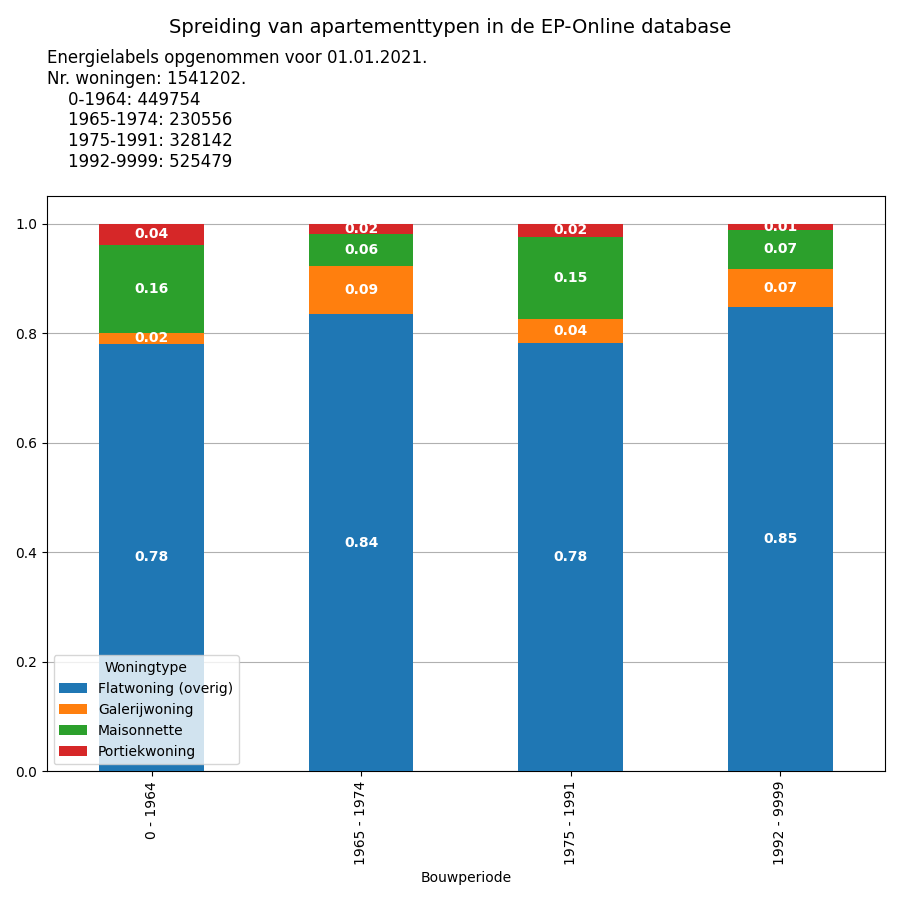
<figcaption>Figure 5: Spreiding van pre-NTA8800 meergezinswoningtypen in
de EP-Online database, <span class="citation"
data-cites="_EP_2023"><span>“<span>EP-Online</span>”</span>
(2023)</span></figcaption>
</figure>

## 3.4 Vormfactor

The vormfactor is calculated as the fraction of the verliesoppervlakte
and gebruiksoppervlakte. The verliesoppervlakte is the sum of all
surface areas that envelope the dwelling, except the surfaces that are
shared with another dwelling. The gebruiksoppervlakte is the area that
is registered for the VBO in the BAG (VBO’s `oppervlakte`).

We compute the vormfactor for each Pand. The required surface areas for
calculating the verliesoppervlakte are part of the 3DBAG since version
`2023.10.08`. The vormfactor of an eengezinswoning is equivalent to the
vormfactor of the Pand.

For appartements, we assign a portion of the surface areas to each
appartement, depending on their type (see
<a href="#sec-meergezins" class="quarto-xref">Section 3.2.3</a>). The
total roof surface area is divided equally among the appartements on the
roof floor. Only 95% of the total wall surface area is used to account
for wall surfaces that cover hallways and other non-dwelling spaces in
the pand. The wall surface area is then divided among each appartement
in a way that the appartements on the hoek are assigned approximately 3x
the wall surface area of a tussen appartement. The total ground surface
area is divided equally among the appartements on the ground floor.

## 3.5 Estimating the energy labels

In order to determine the accurate energy label for a dwelling, the
dwelling needs to be surveyed in-person by a qualified professional.
This is not feasible to do on a national scale. However, we can estimate
the type of the dwelling
(<a href="#sec-woningtype" class="quarto-xref">Section 3.2</a>) and we
know the construction period from the BAG. In addition, we can calculate
the vormfactor for eengezinswoningen accurately, and estimate the
vormfactor for meergezinswoningen (see
<a href="#sec-vormfactor" class="quarto-xref">Section 3.4</a>). Finally,
from RVO (2022) we have a distribution of energy labels for each
combination of the three parameters, dwelling type, construction period
and vormfactor. Then the energy label of an individual dwelling is
selected based on the likelihood of all labels in across the three
variables.

For example, given a dwelling with the parameters of dwelling type
*Flatwoning*, construction period of *1965-1974* and a vormfactor in the
range of *1,50-2,00*, the estimated energy label for the dwelling
depends on the range of available labels, *C-G*, and their probability
(see
<a href="#fig-woon2022-spreiding" class="quarto-xref">Figure 1</a>).

Due to the gaps in the energy label distributions that are presented in
RVO (2022) (see
<a href="#sec-spreiding" class="quarto-xref">Section 2.1</a>), there are
situations where it is impossible to estimate the correct label for a
VBO. For example, the VBO has a registered label *B* in EP-Online,
however, RVO (2022) does not have data for label *B* and the parameters
of the VBO. We consider such labels *impossible*, since with our method
and the limitations of the RVO (2022) data, it is not possible to assign
the correct label. Measuring the *impossible* labels allows us to
evaluate the impact of the gaps in the RVO (2022) data and the
sensitivity or our method.

The individual labels are aggregated per neighborhood to estimate the
energy label distributions for each neighborhood in the Netherlands.

# 4. Validating the energy label estimation

We validate our energy label estimation against the energy labels in the
“EP-Online” (2023) database. We compare the estimated labels to the
EP-Online labels in terms of *deviation*. The *deviation* is calculated
as the numeric, signed distance from one label to the reference label.
Where the distance from a worse label to a better label is positive. For
example, the distance from *A++++* to *G* is *-10*, the distance from
*G* to *A++++* is *10*.

The validation process measures the following aspects.

-   Number of VBO that did not receive an energy label (due to a gap in
    the energy label distribution, see
    <a href="#sec-spreiding" class="quarto-xref">Section 2.1</a>).

-   Percent of labels that match the EP-Online labels exactly. For
    example the estimated label is *A*, then the EP-Online is also *A*
    for the selected VBO.

-   Percent of labels that match the EP-Online labels with one label
    deviation. For example the estimated label is *A*, then the
    EP-Online can be any of *A+*, *A*, *B*.

-   The median, mean, standard deviation, minimum and maximum of
    *deviations* per neighborhood, and for the complete data set.

# 5. Results

## 5.1 Dwelling types

When comparing against the EP-Online data, our dwelling classification
shows 87% accuracy for the eengezingswoningen, and 26% accuracy for the
meergezinswoningen.

## 5.2 Energy labels estimation

From the available *5.385.950* input Pand objects, *4.847.298* received
an energy label.  
Thus, *13%* of objects did not receive a label. The missing labels are
caused by the gaps in energy label distributions of the RVO (2022) .

We have compared our energy label estimation to the labels available in
“EP-Online” (2023).
<a href="#fig-nl-dist-bar" class="quarto-xref">Figure 6</a> shows the
distribution estimated (green) and ep-online energy labels for the
dwellings that are registered on ep-online. We can observe that the most
common estimated energy label is *C*, making up a bit over 25% of the
labels. However, in the ep-online data set, the labels *A* and *C* each
consitute to about 25% of the total labels.

<figure id="fig-nl-dist-bar">
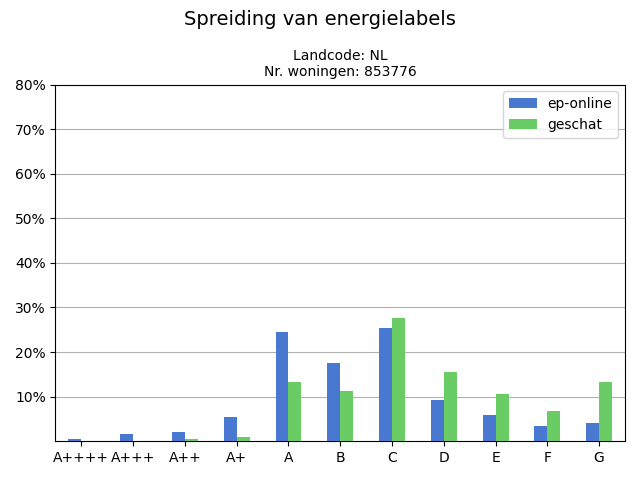
<figcaption>Figure 6: Distribution of estimated and ep-online energy
labels for the dwellings that are registered on ep-online</figcaption>
</figure>

We have found that the mean deviation from the “EP-Online” (2023) labels
is **-1,2**, with a standard deviation of **2,1**.  
In other words, on average our estimated labels are about one label
below the EP-Online labels, with a standard deviation of two labels.

However, if we look at the deviations per label, we get a more detailed
image. <a href="#fig-nl-dist" class="quarto-xref">Figure 7</a> shows
that our *A+++, A++++* are on average 3-5 labels overestimated, while
our *E, F, G* labels are on average 2-4 labels underestimated compared
to the EP-Online data.

<figure id="fig-nl-dist">
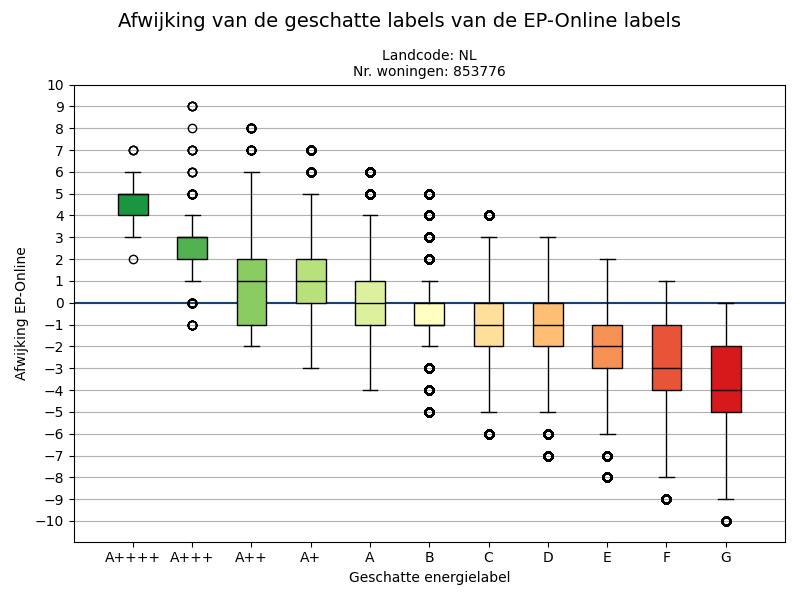
<figcaption>Figure 7: Deviation of the estimated labels from the
EP-Online labels</figcaption>
</figure>

### 5.2.1 Considering only possible labels

Due to the gaps in the energy label distributions of the RVO (2022)
study, *32%* of the dwellings have a label in EP-Online that is missing
from the Voorbeeldwoningen 2022 data (see
<a href="#sec-spreiding" class="quarto-xref">Section 2.1</a>). In such
cases, it is not possible to assign the correct energy label to the
dwelling, since there is no probability for the label. If we limit our
validation to those dwellings where the correct label does have a
probability in energy label distributions, we gain insight on the impact
of the gaps in the energy label distributions.

When comparing only the possible labels, the mean deviation from the
“EP-Online” (2023) labels is **-0,6**, with a standard deviation of
**1,6**.

# 6. Conclusions

The results show that the most common estimated energy label is *C*,
with about X% of dwellings having this label. On average, the estimated
labels are one label below the true label, with a standard deviation of
two labels. The most accurate label is *B*, with with the lowest median
deviation from the ep-online labels, followed by the label *A*.

Our findings indicate that the NTA8800 energy labels in the EP-Online
database have sufficient coverage to be used as a validation set for
developing large area, national methods in the future. However, the
energy labels that were determined with the NTA8800 method use a
different appartement classification than what is used by the WoON 2018
and Voorbeeldwoningen 2022 studies. In our method we follow the
appartement classification of the NTA8800 labels, therefore a conversion
between the two classification is needed. For the conversion we follow
the statistical distribution of appartement types that we found in the
EP-Online data set, because to the best of our knowledge there is no
deterministic method to do this conversion. Therefore, the appartement
type conversion in itself adds more uncertainty to the energy label
estimation of appartements.

Due to the lack of national data on the 3D location of apartements, our
method for estimating the horizontal and vertical position of an
appartement is guesswork and thus inaccurate. Therefore in its current
state we do not recommend to use results for meergezinswoningen. In our
results, 44% of dwellings are appartements.

Our results show that the gaps in the Voorbeeldwoningen 2022 energy
label distributions have a significant impact on the accuracy of the
estimated labels (see
<a href="#sec-only-possible" class="quarto-xref">Section 5.2.1</a>),
impacting 32% of the estimated labels. For this reason we recommend to
adapt the Voorbeeldwoningen study so that the energy label distributions
are as complete as possible.

# 7. References

“EP-Online.” 2023. <https://www.ep-online.nl/>.

RVO. 2022. “Voorbeeldwoningen 2022 - Bestaande Bouw.” Technical report
RVO-231-2022/BR-DUZA. Rijksdienst voor Ondernemend Nederland.